In [6]:
import jax
import proplot as pplt

In [7]:
import jax.numpy as jnp

In [8]:
# code from galsim
# // This is Gary's original version with F''''(j) = 0, but f''(x) is not continuous at
# // x = 1,2,3.
# if (x <= 1.)
#     return 1. + x*x*x*(-95./12. + x*(23./2. + x*(-55./12.)));
# else if (x <= 2.)
#     return (x-1.)*(x-2.)*(-23./4. + x*(29./2. + x*(-83./8. + x*(55./24.))));
# else if (x <= 3.)
#     return (x-2.)*(x-3.)*(x-3.)*(-9./4. + x*(25./12. + x*(-11./24.)));
# else
#     return 0.;

def _one(x):
    return 1. + x*x*x*(-95./12. + x*(23./2. + x*(-55./12.)))

def _two(x):
    return (x-1.)*(x-2.)*(-23./4. + x*(29./2. + x*(-83./8. + x*(55./24.))))

def _three(x):
    return (x-2.)*(x-3.)*(x-3.)*(-9./4. + x*(25./12. + x*(-11./24.)))

@jax.jit
def _quintic(y):
    y = jnp.abs(y)
    msk_le1 = y <= 1
    msk_le2 = y <= 2
    msk_le3 = y <= 3
    return jnp.piecewise(y, [msk_le1, (~msk_le1) & msk_le2, (~msk_le2) & msk_le3], [_one, _two, _three, lambda x: jnp.array(0)])


@jax.jit
def _quintic_interp1d(x, xp, yp):
    dx = xp[1] - xp[0]
    xi = jnp.floor((x - xp[0])/dx).astype(jnp.int32)
    n = xp.shape[0]

    def _body(i, args):
        y, xi, xp, yp = args
        xind = xi + i
        msk = (xind >= 0) & (xind < n)
        _x = (x - xp[xind])/dx
        y += jnp.where(msk, _quintic(_x)*yp[xind], 0)
        return [y, xi, xp, yp]
        
    return jax.lax.fori_loop(-3, 4, _body, [jnp.zeros_like(x), xi, xp, yp])[0]


@jax.jit
def _quintic_interp2d(x, y, xp, yp, zp):
    orig_shape = x.shape
    x = x.ravel()
    dx = xp[1] - xp[0]
    xi = jnp.floor((x - xp[0])/dx).astype(jnp.int32)
    nx = xp.shape[0]

    y = y.ravel()
    dy = xp[1] - xp[0]
    yi = jnp.floor((y - yp[0])/dy).astype(jnp.int32)
    ny = yp.shape[0]
    
    def _body_1d(i, args):
        z, wy, msky, yind, xi, xp, zp = args
        
        xind = xi + i
        mskx = (xind >= 0) & (xind < nx)
        _x = (x - xp[xind])/dx
        wx = _quintic(_x)

        w = wx * wy
        msk = msky & mskx
        z += jnp.where(msk, zp[yind, xind] * w, 0)
        
        return [z, wy, msky, yind, xi, xp, zp]
    
    
    def _body(i, args):
        z, xi, yi, xp, yp, zp = args
        yind = yi + i
        msk = (yind >= 0) & (yind < ny)
        _y = (y - yp[yind])/dy
        wy = _quintic(_y)
        z = jax.lax.fori_loop(-3, 4, _body_1d, [z, wy, msk, yind, xi, xp, zp])[0]
        return [z, xi, yi, xp, yp, zp]
        
    z = jax.lax.fori_loop(-3, 4, _body, [jnp.zeros_like(x, dtype=jnp.float32), xi, yi, xp, yp, zp])[0]    
    return z.reshape(orig_shape)

In [9]:
from functools import partial


@partial(jax.jit, static_argnums=1)
def _small(x, n):
    # from galsim
    # // res = n/(pi x)^2 * sin(pi x) * sin(pi x / n)
    # //     ~= (1 - 1/6 pix^2) * (1 - 1/6 pix^2 / n^2)
    # //     = 1 - 1/6 pix^2 ( 1 + 1/n^2 )
    # double pix = M_PI*x;
    # double temp = (1./6.) * pix*pix;
    # s = pix * (1. - temp);
    # res = 1. - temp * (1. + 1./(_nd*_nd));
    # // For x < 1.e-4, the errors in this approximation are less than 1.e-16.    

    pix = jnp.pi * x
    temp = pix * pix / 6.0
    s = pix * (1.0 - temp)
    return 1.0 - temp * (1.0 + 1.0 / n / n)


@partial(jax.jit, static_argnums=1)
def _large(x, n):
    # from galsim
    # // Above n=7, there isn't much advantage anymore to specialization.
    # // The second sin call isn't much slower than the multiplications
    # // required to get sin(pi x) from sin(pi x/n)
    # s = sin(M_PI*x);
    # double sn = sin(M_PI*x/_nd);
    # res = (_nd/(M_PI*M_PI)) * s*sn/(x*x);
    pix = jnp.pi * x
    s = jnp.sin(pix)
    sn = jnp.sin(pix / n)
    return s * sn / pix / pix * n


@partial(jax.jit, static_argnums=1)
def _lanczos(y, n):
    y = jnp.abs(y)
    msk_s = y <= 1e-4
    msk_l = y <= n
    return jnp.piecewise(y, [msk_s, (~msk_s) & msk_l], [_small, _large, lambda x, n: jnp.array(0)], n)


@partial(jax.jit, static_argnums=3)
def _lanczos_interp1d(x, xp, yp, n):
    dx = xp[1] - xp[0]
    xi = jnp.floor((x - xp[0])/dx).astype(jnp.int32)
    n = xp.shape[0]

    def _body(i, args):
        y, xi, xp, yp = args
        xind = xi + i
        msk = (xind >= 0) & (xind < n)
        _x = (x - xp[xind])/dx
        y += jnp.where(msk, _lanczos(_x, n)*yp[xind], 0)
        return [y, xi, xp, yp]
        
    return jax.lax.fori_loop(-n, n+1, _body, [jnp.zeros_like(x), xi, xp, yp])[0]


@partial(jax.jit, static_argnums=5)
def _lanczos_interp2d(x, y, xp, yp, zp, n):
    orig_shape = x.shape
    x = x.ravel()
    dx = xp[1] - xp[0]
    xi = jnp.floor((x - xp[0])/dx).astype(jnp.int32)
    nx = xp.shape[0]

    y = y.ravel()
    dy = xp[1] - xp[0]
    yi = jnp.floor((y - yp[0])/dy).astype(jnp.int32)
    ny = yp.shape[0]
    
    def _body_1d(i, args):
        z, wy, msky, yind, xi, xp, zp = args
        
        xind = xi + i
        mskx = (xind >= 0) & (xind < nx)
        _x = (x - xp[xind])/dx
        wx = _lanczos(_x, n)

        w = wx * wy
        msk = msky & mskx
        z += jnp.where(msk, zp[yind, xind] * w, 0)
        
        return [z, wy, msky, yind, xi, xp, zp]
    
    
    def _body(i, args):
        z, xi, yi, xp, yp, zp = args
        yind = yi + i
        msk = (yind >= 0) & (yind < ny)
        _y = (y - yp[yind])/dy
        wy = _lanczos(_y, n)
        z = jax.lax.fori_loop(-n, n+1, _body_1d, [z, wy, msk, yind, xi, xp, zp])[0]
        return [z, xi, yi, xp, yp, zp]
        
    z = jax.lax.fori_loop(-n, n+1, _body, [jnp.zeros_like(x, dtype=jnp.float32), xi, yi, xp, yp, zp])[0]    
    return z.reshape(orig_shape)

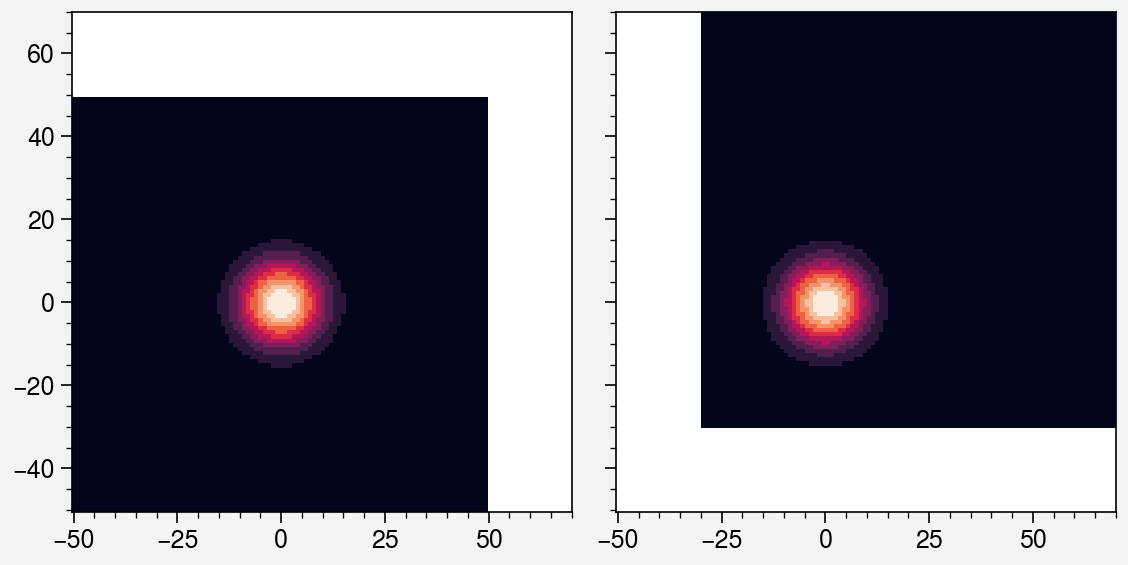

In [10]:
xp, yp = jnp.meshgrid(jnp.arange(100), jnp.arange(100))
xp -= xp.shape[0] // 2
yp -= yp.shape[0] // 2

zp = jnp.exp(-(xp**2 + yp**2)/10**2)

x = xp + 20.5
y = yp + 20.5

xp = xp[0, :]
yp = yp[:, 0]

z = _lanczos_interp2d(x, y, xp, yp, zp, 5)

fig, axs = pplt.subplots(nrows=1, ncols=2, share=4)

axs[0].pcolormesh(xp, yp, zp, cmap="rocket")

axs[1].pcolormesh(x[0, :], y[:, 0], z, cmap="rocket")

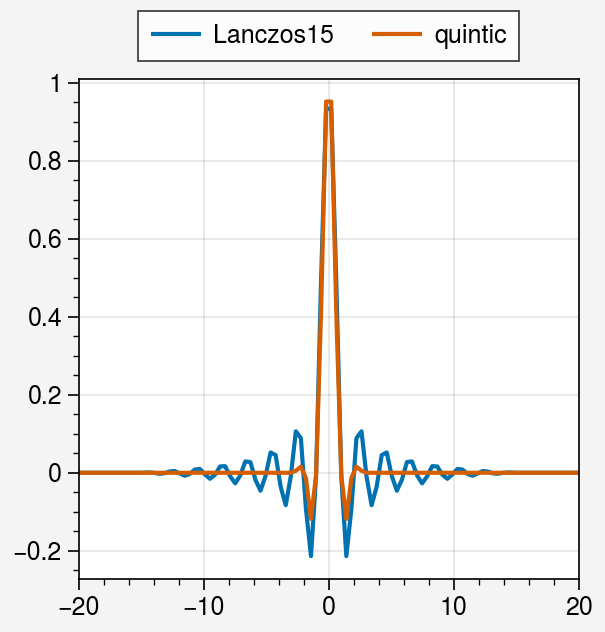

In [221]:
y = jnp.linspace(-20, 20, 100)

fig, axs = pplt.subplots()

m = []
yf = _lanczos(y, 15)
m.append(axs.plot(y, yf, label="Lanczos15"))
yf = _quintic(y)
m.append(axs.plot(y, yf, label="quintic"))

axs.legend(m, loc="t")

In [222]:
# def _interp_one(x, xp, yp):
#     dx = xp[1] - xp[0]
#     xi = jnp.floor((x - xp[0])/dx).astype(jnp.int32)
#     n = xp.shape[0]

#     def _eval(y, xind, dx, xp, yp):
#         _x = (x - xp[xind])/dx
#         y = y + _quintic(_x)*yp[xind]
#         return y

#     def _pass(y, xind, dx, xp, yp):
#         return y

#     y = 0.0
#     for i in range(-3, 4, 1):
#         xind = xi + i
#         y = jax.lax.cond(
#             (xind >= 0) & (xind < n),
#             _eval,
#             _pass,
#             y, xind, dx, xp, yp,
#         )
#     return y


# xp = jnp.arange(100) / 100.0 * 4.0 * jnp.pi
# yp = jnp.sin(xp)
# x = xp + 0.05
# y = _interp_one(1.2, xp, yp)


# _interp = jax.jit(jax.vmap(_interp_one, in_axes=(0, None, None)))

# xp = jnp.arange(100**2) / 100.0 * 4.0 * jnp.pi
# yp = jnp.sin(xp)
# x = xp + 0.05

In [223]:
xp = jnp.arange(100) / 100.0 * 4.0 * jnp.pi
yp = jnp.sin(xp)
x = xp + 0.05

In [232]:
%%timeit

y = _lanczos_interp1d(x, xp, yp, 3)

211 µs ± 513 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [233]:
%%timeit

y = _quintic_interp1d(x, xp, yp)

8.07 µs ± 32.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


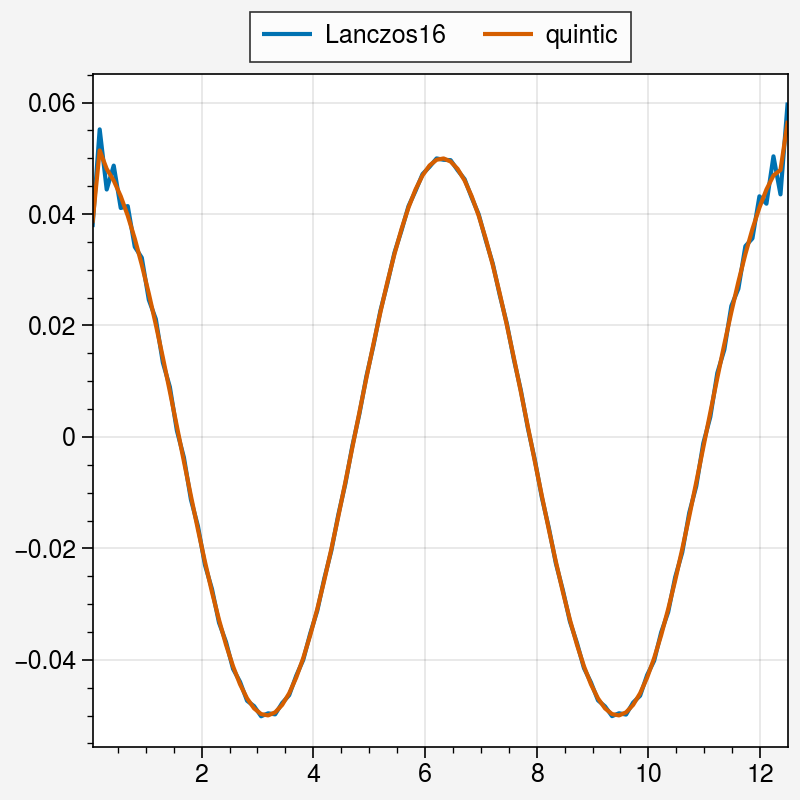

In [229]:

fig, axs = pplt.subplots(figsize=(4, 4))

m = []
y = _lanczos_interp1d(x, xp, yp, 16)
m.append(axs.plot(x, y-yp, label="Lanczos16"))

y = _quintic_interp1d(x, xp, yp)
m.append(axs.plot(x, y-yp, label="quintic"))

axs.legend(m, loc="t")

In [142]:
y = jnp.linspace(-10, 10, 100)
yf = _quintic(y)

In [53]:
import proplot as pplt

<a list of 1 Line2D objects>

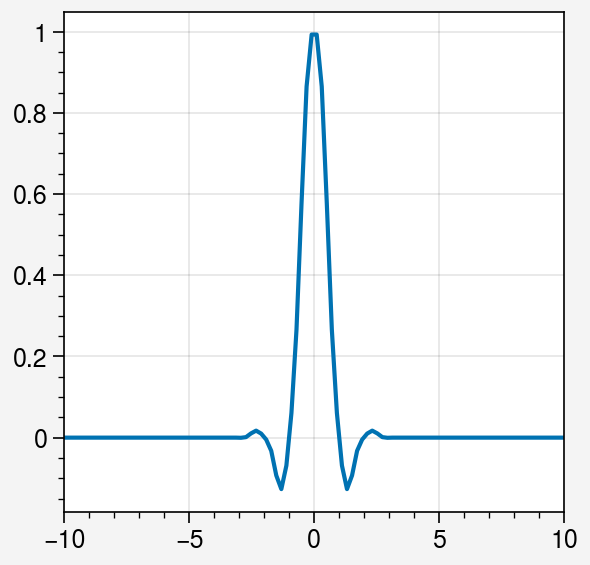

In [55]:
list(i for i in range(-3, 4, 1))

[-3, -2, -1, 0, 1, 2, 3]

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[100])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

In [47]:
fig, axs = pplt.subplots()

axs.plot(y, yf)

Array([ 0.        ,  0.12566371,  0.25132743,  0.37699112,  0.50265485,
        0.62831855,  0.75398225,  0.879646  ,  1.0053097 ,  1.1309733 ,
        1.2566371 ,  1.3823009 ,  1.5079645 ,  1.6336282 ,  1.759292  ,
        1.8849556 ,  2.0106194 ,  2.1362832 ,  2.2619467 ,  2.3876104 ,
        2.5132742 ,  2.638938  ,  2.7646017 ,  2.8902652 ,  3.015929  ,
        3.1415927 ,  3.2672565 ,  3.3929203 ,  3.518584  ,  3.6442475 ,
        3.7699113 ,  3.895575  ,  4.021239  ,  4.1469026 ,  4.2725663 ,
        4.39823   ,  4.5238934 ,  4.649557  ,  4.775221  ,  4.9008846 ,
        5.0265484 ,  5.152212  ,  5.277876  ,  5.4035397 ,  5.5292034 ,
        5.654867  ,  5.7805305 ,  5.9061947 ,  6.031858  ,  6.157522  ,
        6.2831855 ,  6.4088497 ,  6.534513  ,  6.6601763 ,  6.7858405 ,
        6.911504  ,  7.037168  ,  7.1628313 ,  7.288495  ,  7.414159  ,
        7.5398226 ,  7.6654863 ,  7.79115   ,  7.916814  ,  8.042478  ,
        8.16814   ,  8.293805  ,  8.419468  ,  8.545133  ,  8.67

In [11]:
import numpy as np

<a list of 1 Line2D objects>

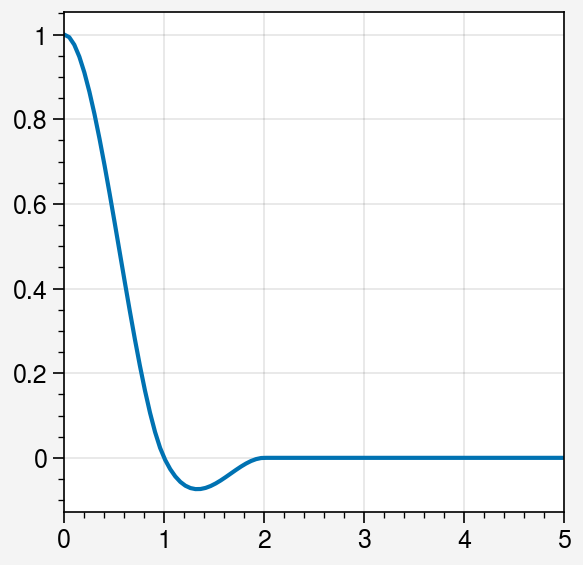

In [13]:
x = np.linspace(0, 5, 100)

def _cubic(x):
    if x < 1.0:
        return 1. + x*x*(1.5*x-2.5)  
    elif x < 2.:
        return -0.5*(x-1.)*(x-2.)*(x-2.)
    else: 
        return 0.
    
fx = np.array([_cubic(xi) for xi in x])

fig, axs = pplt.subplots()

axs.plot(x, fx)